# Composing Through Lyrics

The purpose of this project is to learn the relation between the lyrics of a song and its music. It is certain that different kind of lyrics require some different kind of music that indicate the connotation behind the used words. From a technical point of view, we have two sequences that we are trying to relate:

1) The first sequence is a list of words of the lyrics of the song.

2) The second sequence is a list of notes/chords that compose the music of the song.

With that being said, we built an encoder/decoder seq2seq model with GRU recurrent units to try to capture the relationship between the lyrics and the music.

In order to acquire some training data we needed to get creative. We thought of gathering midi files of songs that already contain the lyrics and use these as training data. Although the idea is valid, but gathering the data was a huge challenge towards this project. Most of the midi files on the internet is either expensive to get (it is the same kind of files that is used for kareoke), or the files are assumed that they contain the lyrics while in reality they do not. Luckily we were able to find http://www.olgris.kiev.ua/des/midi%20lat.html, which was our main source of data. The website contains 230 midi files with all different genres of music.

## Background Knowledge
In order to be able to work with the midi files, we needed to know what a midi file is in the first place in order to look in the right place for the data required. Without going into much detail, midi files are byte-encoded files that include all different information about a piece of music. The most important building units of a midi file are the tracks. A midi file includes a track for every instrument played in that song. However there is one special track, usually that of the piano, that includes also the lyrics. Each track consists of several events of different types. Each event contains then its own metadata that is used when playing the file. There are two important types of events in every track:

1) The "NOTE" event which is translated to a certain sound, and
    
2) The "LYRIC" event that contains the word or words at a specific position.
    
Events in a track are sequential data and are thus played in certain order. This is why the piano track is considered for this project. All notes/chords sequence associated with a sentence is extracted and treated as a training sample.

As mentioned above, midi files are byte-encoded files, and it would have been quite a hassle to work with them as raw files. This is why we used the music21 library developed at MIT https://web.mit.edu/music21/. Before getting started, please follow the installation instructions stated below.

## Installation steps
Please install all packages listed in requirements.txt by running "pip install -r requirements.txt".
In addition to that, spaCy was used for text preprocessing. This is why a spaCy model needs to be downloaded with the command "python -m spacy download en". Ultimately, the package timidity needs to be installed in order to play music in this notebook. Install timidity via the command "sudo apt-get install timidity timidity-interfaces-extra"

## A view on the data
Thanks to music21 and timidity, we can play midi files from a notebook. Here is an example

In [2]:
import numpy as np
import tensorflow as tf
from preprocess import *
import ipdb,os,glob
from tensorflow.contrib.tensorboard.plugins import projector
from sklearn.model_selection import train_test_split
file = "test_midi/14_Years.mid"
play_midi(file)

The lyrics of the song is included also in the midi file. If we were to play it in a terminal using "timidity -filename-", we would get the lyrics as in a kareoke game. Because the piano track is the only track of interest to us, we need to look at the events in order to know the type of the data we are dealing with. Here are 10 events from that track: 

In [3]:
m = midi.MidiFile()
m.open(file)
m.read()
for track in m.tracks:
    lyrics = [ev.data for ev in track.events if ev.type=="LYRIC"]
    temp_stream = midi.translate.midiTrackToStream(track)
    notes = get_notes_from_stream(temp_stream)
    if len(lyrics) > 0:
        break
print(track.events[10:20])

[<MidiEvent DeltaTime, t=96, track=4, channel=None>, <MidiEvent NOTE_ON, t=None, track=4, channel=4, pitch=69, velocity=100>, <MidiEvent DeltaTime, t=0, track=4, channel=None>, <MidiEvent NOTE_ON, t=None, track=4, channel=4, pitch=72, velocity=100>, <MidiEvent DeltaTime, t=0, track=4, channel=None>, <MidiEvent NOTE_ON, t=None, track=4, channel=4, pitch=76, velocity=100>, <MidiEvent DeltaTime, t=0, track=4, channel=None>, <MidiEvent LYRIC, t=None, track=4, channel=None, data=b'I '>, <MidiEvent DeltaTime, t=96, track=4, channel=None>, <MidiEvent NOTE_ON, t=None, track=4, channel=4, pitch=76, velocity=0>]


From these events, we came up with a string representation that would allow us to convert the strings back to notes/chords. The string representation of 20 notes/chords from this track are shown below. As we can see, we convert notes by mapping them to their pitches. As for chords, a string of the normal order representation of each note in the chord separated by a dot is recorded. For the detailed operation, please refer to the "get_notes_from_stream" in preprocess.py

In [4]:
print(notes[110:130])

['A5', 'G5', 'A5', '7.9', 'G5', '7.9', 'A5', 'G5', 'C6', 'A5', '4.9', '4.7.9', '4.9', '2.7', '2.7', '2.5.7', '2.7', '0.5', '0.5', '5.7.0']


At this stage, the data is ready and can be fed to the network.

Special words for the dictionary:

In [5]:
special_words = ["<PAD>", "<GO>", "<END>"]

## Class For Dictionary
The class contains the data and the helper functions for the dictionary to train seq2seq model.
Most important functions are to mapping a list of words(a sentence) to a list of corresponding integer(indeces of words). 

In [6]:
class Seq2Seq_Dictionary:
    def __init__(self, sentences ):
        self.word2index_map = dict()
        self.index2word_map = dict()
        self.vocab_size = 0
        self.init_register(sentences)
        
    # Initiates word2index_map and index2word_map
    # Also extracts the max number of words in the sentences and saves it 
    def init_register(self,sentences):
        global special_words
        current_index = 0
        ## save the maximum length among the sentences. 
        self.max_length = max([len(sentence) for sentence in sentences])
        ### map special words, initially the mappings are empty.
        for word in special_words:
            self.word2index_map[word] = current_index
            self.index2word_map[current_index] = word
            current_index+=1
        
        s = set([item for sublist in sentences for item in sublist])
        self.word2index_map.update({e:i+current_index for i,e in enumerate(s)})
        self.index2word_map.update({v:k for k,v in self.word2index_map.items()})
        self.vocab_size = len(self.index2word_map)
    
    ## Returns the index of the word in the dictionary. It is assumed that the word
    ## will be always in dictionary.
    def get_index(self, word):
        return self.word2index_map[word]
    
    ## Maps a sentence, which is a list of words, to the corresponding list of integers.
    ## Each word is looked up from the map of the dictionary, and as in get_index method,
    ## it is assumed that the word will always be found in the dictionary
    def map_sentence(self, sentence):
        return [self.get_index(i) if i in self.word2index_map else 0 for i in sentence]
    
    ## Returns the word by its index in dictionary.
    def get_word(self, index):
        return self.index2word_map[word]
    
    ## Pads the list of words to <PAD> at the end of the list of words in sentence
    def pad_sentence(self, sentence):
        return  sentence + ["<PAD>"] * (self.max_length - len(sentence)+2)
    
    ## Adds <GO> and <END> to the start and end of the sentence
    def add_start_end_tokens(self, sentence):
        return ["<GO>"] + sentence + ["<END>"]
    
    ## Transforms the sentence in a format suitable for the Neural Network
    def transform_sentence(self, sentence):
        s = self.add_start_end_tokens(sentence)
        s = self.pad_sentence(s)
        s = self.map_sentence(s)
        return s
    
    def reverse_transform(self, sentence):
        return [self.index2word_map[s] for s in sentence if (not self.index2word_map[s] in special_words and s in self.index2word_map)]

#### Create the dictionary

#### Read Musics
data is the lyrics and targets is the target notes

In [7]:
data, targets = get_data_from_dir("test_midi_small/")

Working on test_midi_small/Can't feel my face - The Weeknd.mid
Not adding [] and [b'All', b' rights', b' reserved ']
Working on test_midi_small/Dont Turn Around.mid
Not adding [] and [b'I ', b'will ', b'survived ', b'without ', b'you ']
Not adding [] and [b'Peo', b'ple ', b'in ', b'your ', b'life ', b'they ', b"don't ", b'know ', b"what's ", b'go', b'ing ', b'on ', b' ']
Not adding [] and [b'Too ', b'proud ', b'to ', b'turn ', b'a', b'round ', b"he's ", b'gone] ']


Create input and target dictionaries, and general useful variables. max_len(max_sequence_len and max_notes_len) variables are the sizes of the longest sentences for lyrics and notes.

In [8]:
data_dict = Seq2Seq_Dictionary(data)
target_dict = Seq2Seq_Dictionary(targets)
max_sentence_len = data_dict.max_length
max_notes_len = target_dict.max_length

After creating the dictionary, we need to transform both lyrics and notes by adding the < GO >, < END > and < PAD > words, as necessary and, get the integer representations of the words.

In [9]:
## Transform the data and the targets
transformed_data = [data_dict.transform_sentence(i) for i in data]
transformed_targets = [target_dict.transform_sentence(i) for i in targets]
print(data_dict.max_length)
print(target_dict.max_length)
print(data[10])
print(transformed_data[10])
len(data_dict.index2word_map)

20
81
['when', 'we', 'be', 'deep', 'in', 'love']
[1, 51, 52, 38, 45, 73, 70, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


119

To get the grasp of the data we are dealing, here are some logs

In [10]:
print(f"Size of data vocabulary: {data_dict.vocab_size}")
print(f"Size of targets vocabulary: {target_dict.vocab_size}")

print(f"Max. Length of the data: {data_dict.max_length}")
print(f"Max. Length of the target: {target_dict.max_length}")
print(f"Sample data: {data[10]}")
print(f"Corresponding targets: {targets[2]}")
print(f"Sample transformed data: {transformed_data[10]}")
print(f"Corresponding transformed targets: {transformed_targets[2]}")

Size of data vocabulary: 119
Size of targets vocabulary: 84
Max. Length of the data: 20
Max. Length of the target: 81
Sample data: ['when', 'we', 'be', 'deep', 'in', 'love']
Corresponding targets: ['2', '4.5', 'F#2', '2.3.4.6', 'F1', 'F#2', 'E1', 'F1', '6.11.0', 'F#2', '2.3.4.6', '0', '2', 'G1', 'A1', 'B-2', '2', 'C2', '6.11.0', '0', 'A1', 'F#2', '9', '2.3.4.6', 'A1', 'F#2', 'G1', 'A1', '6.11.0', 'F#2', '2.3.4.6', '0', 'G1', '2', 'F#2', '2', 'A1', 'A1', '6.11.0', '0', 'A1', 'F#2', '9', '2.3.4.6', 'A1', 'F#2', 'G1', 'A1', '6.11.0', '3', '2.6', 'D2']
Sample transformed data: [1, 51, 52, 38, 45, 73, 70, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Corresponding transformed targets: [1, 26, 50, 70, 53, 62, 70, 21, 62, 10, 70, 53, 58, 26, 33, 45, 17, 26, 77, 10, 58, 45, 70, 63, 53, 45, 70, 33, 45, 10, 70, 53, 58, 33, 26, 70, 26, 45, 45, 10, 58, 45, 70, 63, 53, 45, 70, 33, 45, 10, 79, 68, 30, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Model Creation
Tensorflow initialization

In [11]:
tf.reset_default_graph()

### General Model Variables 

In [12]:
embedding_size= 256
hidden_units = 256
keep_prob=0.5 # Dropout parameter
batch_size = 32
sentence_vocab_size = len(data_dict.index2word_map)
notes_vocab_size = len(target_dict.index2word_map)
learning_rate = 1e-4
SAVE_PATH = 'logs/Compose/' ### Save the trained model
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)
    
test_train_ratio = 0.2  ### ratio of the data to be allocated as test(actually validation) data.

#### Model Inputs
\_encoder\_inputs has size of max_sentence_len+2 because we have extra < GO > and < END > variables in the input.

To differentiate between train and test time, which changes the graph in our model, \_is\_training input is presented.

\_target\_notes has column size of max\_notes\_len+1, contrary to \_encoder_inputs, because the < GO > word, at the beginning of the decoder is given by default, and actually the decoder does not try to predict the < GO > word. It is the first input to the decoder, but the first output of the decoder is actually the first note/chord in the notes sequence. So, we need to exclude < GO > from the \_target_notes.

In [13]:
_encoder_inputs = tf.placeholder(shape=(batch_size, max_sentence_len+2),
                                 dtype=tf.int32, name='encoder_inputs')
_encoder_seq_len = tf.placeholder(shape=(batch_size),
                                 dtype=tf.int32, name='encoder_seq_lens')
_is_training = tf.placeholder(tf.bool,name="training_or_test")
_target_notes = tf.placeholder(shape=(batch_size, max_notes_len+1) , 
                               dtype=tf.int32, name='target_notes')

### Encoder
Encoder part is created here. First the words in the lyrics are put in an embedding layer. Then the a bidirectional GRU cell is used after the embedding, which contains forward and backward GRU cells, and after putting the into the dropout layers, they are put in bidirectional_dynamic_rnn, with sequence length is defined with the input \_encoder_seq_len. 

Then the output and the hidden states of it is taken. We have output and a hidden state for both forward and backward GRUs. To use them in the decoder, we concatenate hidden states and outputs of each. The hidden state will be used as the initial hidden state of the GRU in the decoder, and outputs will be used to create scores.

In [14]:
with tf.variable_scope("encoder") as encoder_sc:
    ## embeddings
    enc_embed_var = tf.Variable(
        tf.random_uniform([sentence_vocab_size,
                           embedding_size],
                          -1.0, 1.0), name='embedding')
    
    enc_embed = tf.nn.embedding_lookup(enc_embed_var, _encoder_inputs)
    
    # Forward direction cell
    enc_gru_fw = tf.nn.rnn_cell.GRUCell(hidden_units)
    # Backward direction cell
    enc_gru_bw = tf.nn.rnn_cell.GRUCell(hidden_units)
    
    enc_dropout_fw = tf.contrib.rnn.DropoutWrapper(enc_gru_fw, input_keep_prob=keep_prob,
                                                   output_keep_prob=keep_prob)

    enc_dropout_bw = tf.contrib.rnn.DropoutWrapper(enc_gru_bw, input_keep_prob=keep_prob,
                                                   output_keep_prob=keep_prob)

    
    ## here the state variable contains only the last state information of the cells
    enc_rnn_outputs,enc_rnn_state=tf.nn.bidirectional_dynamic_rnn(enc_dropout_fw,
                                                          enc_dropout_bw, 
                                                          enc_embed,
                                                          sequence_length=_encoder_seq_len,
                                                          dtype=tf.float32)
    ## Get forward and backward last states and outputs of the GRU
    enc_rnn_outputs_fw,enc_rnn_outputs_bw  = enc_rnn_outputs
    enc_rnn_fw_state,enc_rnn_bw_state  = enc_rnn_state
    
    ## concat states and outputs
    _enc_last_state = tf.concat((enc_rnn_bw_state, enc_rnn_fw_state),1)
    _enc_output = tf.concat((enc_rnn_outputs_bw,enc_rnn_outputs_fw),2)

In [15]:
print(_enc_last_state.get_shape())
print(_enc_output.get_shape())


(32, 512)
(32, 22, 512)


### Decoder
Decoder part is created here. Because bidirectional GRU  is used in the encoder part, the state vector is twice size of an GRU cell with same number of hidden units. So, after concatanating the last states of GRUs, here the hidden size of GRU should be doubled.

#### Decoder  With While Loop
We are using a while loop structure because each resulting hidden state of the GRU in the decoder, will be an input to the network to calculate scores of the next word in the same sentence.

Following is the condition for the while loop. As this returns true, the while_loop will be running and giving the next word From the first word at each sentence, iteration should go until the last note/chord, except the < END >. Since the < END > word is not an 

In [16]:

def decoder_condition(t, *args):
    return t<max_notes_len+1

Decoder as a function to be called from the body of the while_loop. Note that, in order to reuse the network after each word, first we need to initialize it then set the reuse to True.

In [17]:
ones = np.ones((batch_size))
zeros = np.zeros((batch_size))
def decoder(_decoder_inputs,_hidden_state,reuse=None):
    with tf.variable_scope("decoder",reuse=reuse) as decoder_sc:
        ## Luong's multiplicative score --> score = _hidden_state.T * W * _enc_output

        ### First the W * _enc_output part is handled. It is straightforward with a dense layer, 
        ### and its output size should be hidden_size*2, because we have a bidirectional rnn 
        ### in the encoder. Output shape should be (batch_size, max_len, 2*hidden_size)
        ### because later it will be multiplied with (batch_size,2*hidden_size) 
        ### (which could be thought as batch_size, 2*hidden_size,1) to get the score.
        w_times_enc_output = tf.layers.dense(_enc_output, hidden_units*2)
        print("shape of w_times_enc_output:",w_times_enc_output.get_shape())

        ### First hidden state is taken from the encoder's GRUs last hidden state, and the
        ### shape of it is (batch_size, 2*hidden_size). For each input sentence, there is one
        ### hidden state. _hidden_state's size is (batch_size, 2*hidden_size) 
        ### one can think of it as (batch_size, 1,2*hidden_size). Semantically, there is 
        ### only one hidden state vector for each batch item(iteration).
        ### To transpose it, as the formula of Luong's suggests,
        ### we can just expand (batch_size, 2*hidden_size) to (batch_size, 2*hidden_size,1), 
        ### expanding in the 2.nd dimension.
        hidden_state_tr = tf.expand_dims(_hidden_state,2)
        print("shape of enc_last_state_tr:",hidden_state_tr.get_shape())

        ### w_times_enc_output = (batch_size, max_len, 2*hidden_size)
        ### enc_last_state_tr = (batch_size, 2*hidden_size,1)
        ### resulting score = (batch_size, max_len,1)
        score =  tf.matmul(w_times_enc_output,hidden_state_tr)
        print("shape of score:",score.get_shape())

        ### Now the shape of score (batch_size, max_len,1). We have a score for each of the 
        ### input word(input word of the encoder) in a batch. To normalize it, now they are 
        ### putting in a softmax, and 
        ### the normalization should be within a batch, so the axis to apply softmax is
        ### 1.st one, since 0 is used for batches.
        ### Attention weights(attention_w) has same shape with score, which is 
        ### (batch_size, max_len,1)
        attention_w = tf.nn.softmax(score,1)

        ### attention_w (batch_size, max_len,1),   _enc_output (batch_size, max_len,2*hidden_size).
        ### Multiplication operator supports broadcasting, so that this multiplication does not produce
        ### an error. attention_w is broadcasted to be multiplied with each hidden unit of _enc_output,.
        ### which means multiplying each output of the hidden units with the attention weight of the
        ### associated word.
        ### Resulting context_vec is in shape of (batch_size, max_len, 2*hidden_size)
        context_vec = attention_w * _enc_output

        ### To create a context vector for each sentence in the batch, now we are summing
        ### up along the dimension of the max_len(along words in a sentence) 
        ### so that we are left with size (batch_size, 2*hidden_size).
        context_vec = tf.reduce_sum(context_vec, axis=1)
        print("shape of context_vec:",context_vec.get_shape())

        ### Input to the decoder is also put through a embedding layer, since they are
        ### target notes.
        embed_var = lambda: tf.random_uniform([notes_vocab_size,embedding_size],-1.0, 1.0)
        dec_embed_var = tf.Variable(embed_var ,name='decoder_embedding')

        ### Size of the embedded input-> (batch_size, 1, embedding_size)
        dec_embed = tf.nn.embedding_lookup(dec_embed_var, tf.expand_dims(_decoder_inputs,1))

        print("shape of the decoder embedding:",dec_embed.get_shape())

        ### To make the 1.st dimension matching with the embedded input, now the context vector 
        ### is expanded in the 1.st dimension. resulting size is (batch_size, 1, 2*hidden_size)
        context_vec = tf.expand_dims(context_vec, 1)

        ### Concatanate along the second dimension, so the resulting size is
        ### (batch_size, 1, 2*hidden_size + hidden_dim)
        dec_before_gru = tf.concat([context_vec, dec_embed], axis=2)

        ### Since we will be feeding the decoder one input at a time, the sequence length
        ### would be either 0 or 1 depending on the current input of each sentence.
        ### So if the current input is not <PAD>, then the seq len is 1, if it is <PAD> then 
        ### it is just a padding, the seq len is 0.
        all_pads = [target_dict.get_index("<PAD>")]*batch_size
        
        dec_seq_len = tf.cast(tf.where(_decoder_inputs == all_pads, zeros, ones),
                              dtype=tf.float32)

        ### Now the input is ready for the GRU.
        dec_gru = tf.nn.rnn_cell.GRUCell(2*hidden_units)

        dec_dropout = tf.contrib.rnn.DropoutWrapper(dec_gru, input_keep_prob=keep_prob,
                                                       output_keep_prob=keep_prob)

        ### dec_rnn_outputs has shape (batch_size, 1, 2*hidden_size)
        ### dec_rnn_state has shape (batch_size, 2*hidden_size)
        dec_rnn_outputs,dec_rnn_state=tf.nn.dynamic_rnn(cell=dec_dropout, inputs=dec_before_gru, 
                                                        initial_state=_hidden_state,
                                                        sequence_length=dec_seq_len)
        ### To make predictions based on the output of the rnn, now we are reshaping the 
        ### the output to the shape of (batch_size, 2*hidden_size)
        dec_rnn_outputs = tf.squeeze(dec_rnn_outputs)

        ### predictions has the shape of (batch_size, notes_vocab_size). This means we are predicting
        ### only the next word for each sentence. For each sentence, there is a vector of
        ### shape notes_vocab_size which contains the likelihood of the corresponding vocabulary
        ### element for the next word in the sentence.
        preds = tf.layers.dense(dec_rnn_outputs, notes_vocab_size)
    
    return preds, dec_rnn_state,dec_seq_len  #,dec_embed_var.read_value()

In [18]:
#with tf.variable_scope("pred_layer") as pred_layer_sc:  

### Prepare the decoder inputs. 
To reduce the memory usage during the backpropagation, we are putting the each word in each sentences in a batch into a TensorArray.

The size of the decoder inputs is the (batch_size, max_notes_len), aproximately the target notes of the current input batch. First we are transposing it to word major order, so that the [i,] indexing will return the i.th note of the all note sequences in the batch. Then we are going to unstack it, hence we will get a tensorarray of size max_notes_len, each item containing batch_size notes.

## Run Decoder

General variables to run the decoder loop. 

Iteration starts from 1, because we are going to call the decoder to initialize it at the beginning. 

init_outputs stores the output predictions of each iteration.

In [19]:
init_i = tf.constant(1, dtype=tf.int32)
init_outputs = tf.TensorArray(dtype=tf.float32,size=max_notes_len+1,clear_after_read=False)
init_seq_len = tf.TensorArray(dtype=tf.float32,size=max_notes_len+1,clear_after_read=False)
#init_embed_vals = tf.random_uniform([vocab_size,embedding_size],-1.0, 1.0)

Initilize the decoder to be able to "reuse" it, note that reuse is None as default. Initial hidden state is from the encoder and first decoder input is all < GO > character index(which is 1) whose shape is batch_size.  

In [20]:
init_preds,init_hidden_state,temp_seq_len = decoder(
                                        [target_dict.get_index("<GO>")]*(batch_size), 
                                        _enc_last_state)
                                       #init_embed_vals)
init_outputs = init_outputs.write(0, init_preds)
init_seq_len = init_seq_len.write(0, temp_seq_len)

shape of w_times_enc_output: (32, 22, 512)
shape of enc_last_state_tr: (32, 512, 1)
shape of score: (32, 22, 1)
shape of context_vec: (32, 512)
shape of the decoder embedding: (32, 1, 256)


The decoder will be running with the while loop. If we are using the teacher forcing, we need to use decoder_body_teacher_forcing function. But in the test time, we cannot use it, because we dont have any access to labels, so we should be using the prediction from the last word prediction of the decoder.

In the decoder_body_teacher_forcing, decoder_input_arr.read(iteration-1) corresponds the label input. Because the target_notes does not contain a < GO > word at the beginning, but contains < END > at the end, so its shape is max_notes_len+1. To read the i.th word from decoder_input_arr, knowing that iteration variable starts from 1, we need to read the input (i-1).th element from it.

In [21]:
def decoder_body_teacher_forcing(iteration,outputs,body_hidden_state,seq_len,decoder_input_arr):
    temp_preds,temp_hid_state,temp_seq_len = decoder(
                                    _decoder_inputs=decoder_input_arr.read(iteration-1), 
                                    _hidden_state=body_hidden_state,
                                    #_embedding_var = embed_val,
                                    reuse=True)
    outputs = outputs.write(iteration, temp_preds)
    seq_len = seq_len.write(iteration, temp_seq_len)
    return iteration+1, outputs, temp_hid_state,seq_len,decoder_input_arr ##,temp_embed_vals

In this function, we need to fetch the predicted word from the previous decoder iteration. To achieve this, from outputs tensorarray, iteration-1.th element is read and with argmax, the prediction is taken.

In [22]:
def decoder_body_test(iteration,outputs,body_hidden_state,seq_len,fake_decoder_input):
    temp_preds,temp_hid_state,temp_seq_len = decoder(
                                    _decoder_inputs=tf.argmax(outputs.read(iteration-1), axis=1), 
                                    _hidden_state=body_hidden_state,
                                    reuse=True)
    outputs = outputs.write(iteration, temp_preds)
    seq_len = seq_len.write(iteration, temp_seq_len)
    return iteration+1, outputs, temp_hid_state,seq_len,fake_decoder_input       ##,temp_embed_vals

Finally run the while loop. We dont need the latest hidden state and the iteration count, the only thing needed is the predictions of the decoder.

In [23]:
def decoder_while_teacher_f():
    decoder_inputs_tr = tf.transpose(_target_notes)
    decoder_input_arr = tf.TensorArray(dtype=tf.int32, size=max_notes_len+1,clear_after_read=False)
    decoder_input_arr = decoder_input_arr.unstack(decoder_inputs_tr)
    return tf.while_loop(decoder_condition, decoder_body_teacher_forcing, 
                    [init_i, init_outputs, init_hidden_state,init_seq_len,decoder_input_arr])
def decoder_while_test():
    print("testing")
    return tf.while_loop(decoder_condition, decoder_body_test, 
                                [init_i, init_outputs, init_hidden_state,init_seq_len,1.0])
_, dec_preds, _ ,seq_len,_= tf.cond(pred=_is_training, 
                                  true_fn=decoder_while_teacher_f,
                                  false_fn=decoder_while_test
                                 )

shape of w_times_enc_output: (32, 22, 512)
shape of enc_last_state_tr: (32, 512, 1)
shape of score: (32, 22, 1)
shape of context_vec: (32, 512)
shape of the decoder embedding: (32, 1, 256)
testing
shape of w_times_enc_output: (32, 22, 512)
shape of enc_last_state_tr: (32, 512, 1)
shape of score: (32, 22, 1)
shape of context_vec: (32, 512)
shape of the decoder embedding: (32, 1, 256)


Now, dec_preds contains the predictions for each word. So each item in the tensorarray contains (batch_size, vocab_size) shaped tensors. 

Now we are going to create a one tensor whose shape is (batch, max_len,vocab_size). To achieve it, we are going to stack the dec_preds, which results in (max_notes_len, batch_size, vocab_size). Then transpose to get (batch_size,max_notes_len,vocab_size). And the same is done for the seq_len, except the we want seq_len as shape of (batch_size, max_notes_len). 

The all_seq_len variable will be used as a mask to the input. Because if it is 0, then the word is a < PAD >. 

In [24]:
preds = tf.transpose(dec_preds.stack(), [1,0,2])
all_seq_len = tf.to_float(tf.transpose(seq_len.stack()))

### Optimizer and the Loss function

Define the mask for the backpropagation. If the target is < PAD > then don't backpropagate. To do it, we use all_seq_len variable, which already contains data for sequence length for each word.

In [25]:
### If the input word is <PAD>, then there is no need for optimization for that input.

print(preds.shape, _target_notes.shape)
with tf.name_scope("cost"):
    cross_ent = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=preds, labels=_target_notes) * all_seq_len

with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(_target_notes,
                                  tf.argmax(preds, 2,output_type=tf.int32))
    accuracy = tf.reduce_mean(tf.to_float(correct_prediction)) *100
    acc_summary = tf.summary.scalar("Accuracy", accuracy)
### mean of the cross entropy is the loss of this batch
with tf.name_scope("loss"):
    loss = tf.reduce_mean(cross_ent)
    loss_summary = tf.summary.scalar("Loss", loss)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(cross_ent)

saver = tf.train.Saver(max_to_keep=4, keep_checkpoint_every_n_hours=0.5)
# sess.run(tf.global_variables_initializer())

(32, ?, 84) (32, 82)


## Run the code Session

In [33]:
sess.close()
sess = tf.InteractiveSession()

Get all the data in the correct format

In [34]:
%load_ext autoreload
%autoreload 2
from preprocess import *
encoder_inputs_, encoder_input_lengths_ = produce_batch(transformed_data)
decoder_targets_, _ = produce_batch(transformed_targets)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
22
83


Split the data to test and train

In [35]:
train_x, test_x, train_seqlens, test_seqlens, train_y, test_y = \
    train_test_split(encoder_inputs_.T, encoder_input_lengths_, decoder_targets_.T, 
                     test_size=test_train_ratio, random_state=42)

Create randomized batches from all the data at hand. An important detail here is that, size of each batch should be batch_size, less than that is not allowed. Also, the batches are created directly as feed_dict for the session to run.

In [36]:

def generate_batches(x,sequence_len, y, batch_size):
    assert len(x) == len(y)
    shuffeled_pairs = list(zip(x,sequence_len,y))
    np.random.shuffle(shuffeled_pairs)
    x = np.array([i[0] for i in shuffeled_pairs])
    sequence_len = np.array([i[1] for i in shuffeled_pairs])
    ### In this line, we are removing the first words from the sentences which are all <go>
    ### elements. Since we are providing that words by default, we dont need(want) them.
    y = np.array([i[2] for i in shuffeled_pairs])[:,1:]
    res = []
    for i in range(0, len(x), batch_size):
        x_batch = x[i:min(i + batch_size, len(x))]
        seq_len_batch = sequence_len[i:min(i + batch_size, len(sequence_len))]
        y_batch = y[i:min(i + batch_size, len(y))]
        
        if len(x_batch) % batch_size == 0:
            res.append({
                _encoder_inputs: x_batch,
                _encoder_seq_len: seq_len_batch,
                _target_notes: y_batch,
                _is_training:True
            })
    return res

### Model Saving and Checkpoint

In [37]:
train_writer = tf.summary.FileWriter(os.path.join(SAVE_PATH + "/train"),
                                     graph=tf.get_default_graph())
test_writer = tf.summary.FileWriter(os.path.join(SAVE_PATH + "/test"),
                                     graph=tf.get_default_graph())

In [38]:
if glob.glob(SAVE_PATH + '*.meta'):
    print(" restoring an old model and training it further ")
    imported_meta = tf.train.import_meta_graph(glob.glob(SAVE_PATH + '*.meta')[0])
    imported_meta.restore(sess, tf.train.latest_checkpoint(SAVE_PATH))
else:
    sess.run(tf.global_variables_initializer())
    print("Building model from scratch!")


#config = projector.ProjectorConfig()
#embedding = config.embeddings.add()
#embedding.tensor_name = embeddings.name
# Link this tensor to its metadata file (e.g. labels)
#embedding.metadata_path = os.path.join("/logs/TextClass/", 'metadata.tsv')
#projector.visualize_embeddings(train_writer, config)
all_summary_train = tf.summary.merge([acc_summary, loss_summary])
all_summary_test = tf.summary.merge([acc_summary, loss_summary])

epochs = 10
loss_track = []
evaluate_every = 8
for epoch in range(epochs):
    batches = generate_batches(train_x, train_seqlens,train_y, batch_size)
    if epoch == 0:
        print(f"Number of batches: {len(batches)}")
    print(f"Epoch {epoch+1}/{epochs}")
    for e, batch in enumerate(batches) :
        feed_dict = batch
        _, train_loss,train_summary = sess.run([train_step, loss,all_summary_train], feed_dict)
        train_writer.add_summary(train_summary)
        loss_track.append(train_loss)
        if (len(batches)*epoch + e+1)%30 == 0:
            saver.save(sess, os.path.join(SAVE_PATH, "model"))
            test_batch = generate_batches(test_x, test_seqlens,test_y, batch_size)
            test_loss,test_summary = sess.run([ loss,all_summary_test], test_batch[0])
            print(f"Iterations trained:{len(batches)*epoch + e+1 } Loss:{test_loss}")
            test_writer.add_summary(test_summary)

    print(f"Last batch loss: {train_loss}")


Building model from scratch!
Number of batches: 2
Epoch 1/10
Last batch loss: 4.405304908752441
Epoch 2/10
Last batch loss: 3.5950729846954346
Epoch 3/10
Last batch loss: 2.756706714630127
Epoch 4/10
Last batch loss: 2.159853219985962
Epoch 5/10
Last batch loss: 1.5096522569656372
Epoch 6/10
Last batch loss: 1.1104717254638672
Epoch 7/10
Last batch loss: 1.1465448141098022
Epoch 8/10
Last batch loss: 1.1629616022109985
Epoch 9/10
Last batch loss: 1.0602936744689941
Epoch 10/10
Last batch loss: 1.2661948204040527


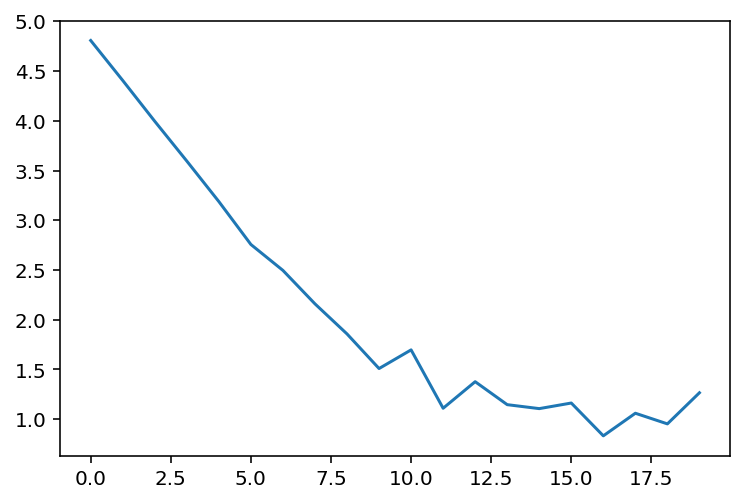

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track) 

compose function is to get a composition given a lyrics line. It would be better if the words in the input dictionary (data_dict).

In [40]:
from preprocess import *
def compose(lyrics):
    lyrics_list, mask = prepare_prediction(lyrics, batch_size, data_dict)
    pred_ = sess.run([preds],
        feed_dict={
            _encoder_inputs: lyrics_list,
            _encoder_seq_len: [sum(i >0 for i in seq) for seq in lyrics_list],
            _is_training:False,
            _target_notes:np.ones((batch_size,target_dict.max_length+1))
        })
    
    pred = np.argmax(pred_[0], axis=2)
    print(np.array(pred).shape)
    pred = [target_dict.reverse_transform(i) for i in pred]
    return pred, mask

In [41]:
lyrics = ["sad","happy","i whine like a baby","i want to love, laugh and smile"]

In [42]:
pred, mask = compose(lyrics)
for e, p in enumerate(pred):
    if e < batch_size-mask:
        print(lyrics[e])
        fname = f"sample_{lyrics[e]}"
        notes_to_midi(p, fname)
        play_midi(f"output/{fname}.mid")

(32, 82)
sad


happy


i whine like a baby


i want to love, laugh and smile


## Conclusion and Future Work